### Simulation for in-play 'bookmaking'
 - laying all horses at % lesser than bsp (null model - e.g. all 10% less than bsp)
 - determining if matched (on previous data)
 - calculating returns (on previous data
 - Using two other staking strategies after this (based on average / quartile decrease)

#### 0 : Importing packages

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pymysql
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#### 1 : Importing data

In [326]:
connection = pymysql.connect(host='localhost', user='root', passwd ='xboxpass32', database = 'smartform')
cursor = connection.cursor()

query = ''' SELECT race_id, runner_id, prize_money, num_runners, historic_betfair_win_prices.bsp, historic_betfair_win_prices.inplay_min, inplay_traded
            FROM historic_races
            JOIN historic_runners USING (race_id) JOIN historic_betfair_win_prices ON race_id=sf_race_id
                 AND
                 runner_id = sf_runner_id
            WHERE(CAST(historic_races.meeting_date AS Datetime) >= '2015-01-01')
            ORDER BY race_id, runner_id
        '''
cursor.execute(query)
rows = cursor.fetchall()

start = query.find('SELECT') + 7
end = query.find('\n            FROM', start)
names = query[start:end].split(', ')

df = pd.DataFrame(list(rows), columns=names)
del rows

print('No. Runners : ', len(df.index), '\nNo. Races : ', df['race_id'].nunique())
df.head(3)

603787

No. Runners :  603787 
No. Races :  64243


,race_id,runner_id,prize_money,num_runners,historic_betfair_win_prices.bsp,historic_betfair_win_prices.inplay_min,inplay_traded
0,494609,1060410,NaN,12,12.50,10.00,8680
1,494609,2055946,76862.4,12,8.06,3.10,17662
2,494609,2061900,19359.0,12,18.91,10.00,5080


#### 2 : Data Preprocessing

In [327]:
# data processing for 'win'
df = df.loc[df['historic_betfair_win_prices.bsp'] != 0]
df = df.loc[df['historic_betfair_win_prices.inplay_min'] != 0]
### removing historic_betfair_win_prices.inplay_min == 1000 for all runners...
df['win'] = np.where(df['prize_money'] == df.groupby('race_id')['prize_money'].transform(np.max), 1, 0)

#### 3 : Finding unique race-ids

In [328]:
race_ids = df['race_id'].unique()
race_ids_low = df.loc[df['num_runners'] <5]['race_id'].unique()

#### 4 : Simulation

##### 4.1 : Simluation - constant price, constant size (changing price for each run)
(Price varied based on 'Implied Probability' percentage increase. e.g. 1.1 = 10% increase, 2 = 100% increase, with a cap at 100% 1.01)

In [ ]:
test_df = df[['race_id','historic_betfair_win_prices.bsp', 'historic_betfair_win_prices.inplay_min', 'win']].copy()

In [ ]:
ps = [1.1, 1.5, 2, 5, 10, 15, 20, 30, 40, 50, 100, 150, 200, 500]
matches = []
pl_sums = []
pl_means = []
for p in ps:
    
    test_df['bsp_prob'] = round(np.power(test_df['historic_betfair_win_prices.bsp'].astype(float), -1), 5)
    test_df['lay_prob'] = test_df['bsp_prob'] * p
    test_df['lay_price'] = np.power(test_df['lay_prob'], -1)
    test_df['lay_price'] = np.where(test_df['lay_price'] <= 1.0, 1.01, test_df['lay_price'])
    test_df['lay_size'] = 2
    test_df['match'] = np.where(test_df['historic_betfair_win_prices.inplay_min'] < test_df['lay_price'], 1, 0)
    test_df['pl'] = np.where(test_df['match'] == 0, 0,
                                  np.where(test_df['win'] == 0, test_df['lay_size'] * 0.95, -(test_df['lay_size'] * (test_df['lay_price'] -1)))
                                 )
    
    pl_sum = round(test_df['pl'].sum(), 2)
    pl_sums.append(pl_sum)
    
    pl_mean = round(test_df['pl'].mean(), 2)
    pl_means.append(pl_mean)
    
    matches_p = round(test_df['match'].sum() / len(test_df.index) * 100, 2)
    matches.append(matches_p)
    
    print(p, ' : ', matches_p, ' : ', pl_mean, ' : ',pl_sum)
# plt.scatter(ps, pl_sums)
plt.scatter(ps, pl_means)

In [ ]:
test_df.head()

##### 4.2 : Simluation - constant price, vary size (vary size using 'dutching', varying price for each run)
(Price varied based on 'Implied Probability' percentage increase. e.g. 1.1 = 10% increase, 2 = 100% increase, with a cap at 100% 1.01)

In [ ]:
test_df = df[['race_id','historic_betfair_win_prices.bsp', 'historic_betfair_win_prices.inplay_min', 'win']].copy()

In [77]:
def bookmaking(df, total_stake):  
    df['ip_book'] = round(df.groupby('race_id')['historic_betfair_win_prices.inplay_min'].transform(lambda x: sum(np.power(x, -1))).astype(float),2)
    df['lp_book'] = round(df.groupby('race_id')['lay_price'].transform(lambda x: sum(np.power(x, -1))).astype(float), 2)
    df['lay_size'] = (df['lay_prob'] / df['lp_book']) * total_stake
    return df

In [ ]:
ps = [1.1, 1.5, 2, 5, 10, 15, 20, 30, 40, 50, 100, 150, 200, 500, 1000]
matches = []
pl_sums = []
pl_means = []
book_means = []
print('P % : ','M% : ','PL Mean : ','Book Mean :', 'PL Sum ')
for p in ps:
    
    test_df['bsp_prob'] = round(np.power(test_df['historic_betfair_win_prices.bsp'].astype(float), -1), 5)
    test_df['lay_prob'] = test_df['bsp_prob'] * p
    test_df['lay_prob'] = np.where(test_df['lay_prob'] > 1.0, 1.0, test_df['lay_prob'])
    test_df['lay_price'] = np.power(test_df['lay_prob'], -1)
    test_df['lay_price'] = np.where(test_df['lay_price'] == 1.0, 1.01, test_df['lay_price'])
    
    test_df = bookmaking(test_df, 20)
    
    test_df['match'] = np.where(test_df['historic_betfair_win_prices.inplay_min'] < test_df['lay_price'], 1, 0)
    test_df['pl'] = np.where(test_df['match'] == 0, 0,
                                  np.where(test_df['win'] == 0, test_df['lay_size'] * 0.95, -(test_df['lay_size'] * (test_df['lay_price'] -1)))
                                 )
    
    pl_sum = round(test_df['pl'].sum(), 2)
    pl_sums.append(pl_sum)
    
    pl_mean = round(test_df['pl'].mean(), 2)
    pl_means.append(pl_mean)
    
    book_mean = test_df['book'].mean()
    book_means.append(book_mean)
    
    matches_p = round(test_df['match'].sum() / len(test_df.index) * 100, 2)
    matches.append(matches_p)
    
    print(p, ' : ', matches_p, ' : ', pl_mean, ' : ', book_mean, ' : ', pl_sum)
    
plt.scatter(ps, pl_means)

##### 4.3 : Simulation - vary price, vary size (vary size using 'dutching', varying price for each runner)
(Price varied based on mean (bsp_prob - ip_prob difference) for each bsp_prob)

In [5]:
# establishing how far prices decrease by for each bsp_prob
prices_df = df[['race_id', 'historic_betfair_win_prices.bsp', 'historic_betfair_win_prices.inplay_min']].copy()
prices_df['bsp_prob'] = round(np.power(prices_df['historic_betfair_win_prices.bsp'].astype(float), -1), 2)
prices_df['ip_prob'] = round(np.power(prices_df['historic_betfair_win_prices.inplay_min'].astype(float), -1), 2)
prices_df['dif_prob'] = prices_df['ip_prob'] - prices_df['bsp_prob']
prices_df.head()

,race_id,historic_betfair_win_prices.bsp,historic_betfair_win_prices.inplay_min,bsp_prob,ip_prob,dif_prob
0,494609,12.50,10.00,0.08,0.10,0.02
1,494609,8.06,3.10,0.12,0.32,0.20
2,494609,18.91,10.00,0.05,0.10,0.05
3,494609,2.81,1.01,0.36,0.99,0.63
4,494609,26.48,10.00,0.04,0.10,0.06


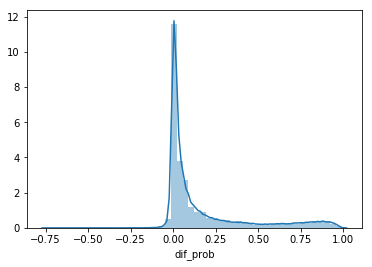

In [6]:
sns.distplot(prices_df['dif_prob'])

<Figure size 1080x576 with 0 Axes>

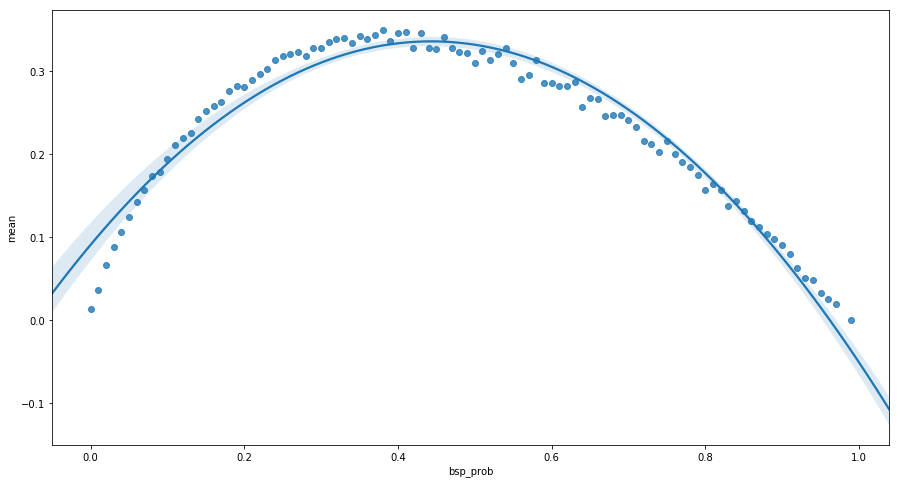

In [92]:
prices_groupby = prices_df.groupby('bsp_prob').agg({'dif_prob':['count',np.mean]})
prices_groupby.columns = prices_groupby.columns.get_level_values(0)
prices_groupby.reset_index(inplace=True)
prices_groupby.columns = ['bsp_prob', 'count', 'mean']
plt.figure(figsize=(15,8))
sns.regplot(x=prices_groupby['bsp_prob'], y=prices_groupby['mean'], order = 2)

In [8]:
prices_dict = dict(zip(prices_groupby['bsp_prob'], prices_groupby['mean']))

#### Decreasing price based on quartile of previous dif_prob for each bsp_prob

In [119]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

In [271]:
# finding price decreases ----
# creating dataframe
prices_df = df[['race_id', 'historic_betfair_win_prices.bsp', 'historic_betfair_win_prices.inplay_min']].copy()
prices_df['bsp_prob'] = round(np.power(prices_df['historic_betfair_win_prices.bsp'].astype(float), -1), 5)
prices_df['ip_prob'] = round(np.power(prices_df['historic_betfair_win_prices.inplay_min'].astype(float), -1), 5)
prices_df['dif_prob'] = prices_df['ip_prob'] - prices_df['bsp_prob']

prices_df['bsp_binned'] = pd.cut(prices_df['bsp_prob'], np.arange(0.00, 1.05, 0.05))

prices_groupby = prices_df.groupby('bsp_binned').agg({'dif_prob':[percentile(10), percentile(25), percentile(50),
                                                                percentile(75), percentile(90), percentile(99)]})
prices_groupby.reset_index(inplace=True)
prices_groupby.columns = prices_groupby.columns.droplevel()
prices_groupby.rename(columns={'': 'bsp_binned'}, inplace=True)
# prices_groupby["bsp_binned"] = prices_groupby["bsp_binned"].apply(lambda x: x.mid)

# plt.figure(figsize=(15,8))
# sns.violinplot(x='bsp_binned', y='dif_prob', data=prices_df)
# prices_groupby

In [ ]:
# experimenting with different price decreases 

In [395]:
# list to append dfs
dfs = []
results_dfs = []

# each df generated by amount of price change
for col in prices_groupby.loc[:, prices_groupby.columns != 'bsp_binned']:
    prices_dict = dict(zip(prices_groupby['bsp_binned'], prices_groupby[col]))
    
    test_df = df[['race_id', 'num_runners', 'historic_betfair_win_prices.bsp', 'historic_betfair_win_prices.inplay_min', 'win']].copy()
    test_df = test_df.loc[test_df['race_id'].isin(race_ids)] # all races in sample at the moment

    test_df['bsp_prob'] = round(np.power(test_df['historic_betfair_win_prices.bsp'].astype(float), -1), 5)
    test_df['bsp_binned'] = pd.cut(test_df['bsp_prob'], np.arange(0.00, 1.05, 0.05))
    test_df["bsp_binned"] = test_df["bsp_binned"].apply(lambda x: x.mid)
    test_df['bsp_prob_add'] = test_df['bsp_binned'].map(prices_dict).fillna(0) # fill with zero - no change
    
    test_df['lay_prob'] = test_df['bsp_prob'] + test_df['bsp_prob_add']
    test_df['lay_prob'] = np.where(test_df['lay_prob'] > 1.0, 1.0, test_df['lay_prob'])
    test_df['lay_prob'] = np.where(test_df['lay_prob'] == 0, 0.01, test_df['lay_prob'])
    
    test_df['lay_price'] = np.power(test_df['lay_prob'], -1)
    test_df['lay_price'] = np.where(test_df['lay_price'] == 1.0, 1.01, test_df['lay_price'])
    test_df = bookmaking(test_df, 20)
    test_df['match'] = np.where(test_df['historic_betfair_win_prices.inplay_min'] < test_df['lay_price'], 1, 0)
    test_df['pl'] = np.where(test_df['match'] == 0, 0,
                             np.where(test_df['win'] == 0, test_df['lay_size'] * 0.95, -(test_df['lay_size'] * (test_df['lay_price'] -1)))
                            )
    print(round(test_df['pl'].sum(), 1))
    dfs.append(test_df)
    
    results_dfs.append(test_df.groupby('race_id').agg({'pl':'sum', 'lp_book':'first',
                                                       'match' : 'sum', 'num_runners' : 'first'}).reset_index())

-139239.4
-141665.7
-105375.9
-36006.4
-7636.9
155.6


In [ ]:
# plotting pl for each price strategy

In [396]:
# for plotting_df in plotting_dfs:
#     plt.figure(figsize=(7,3))
#     sns.distplot(plotting_df['pl'])
    

In [ ]:
# plotting pl vs lp_book for each strategy

In [397]:
# for results_df in results_dfs:
#     plt.figure(figsize=(7,3))
#     sns.scatterplot(results_df['lp_book'], plotting_df['pl'])

In [ ]:
# investigating relationship between pl, lp_book, matches to understand losses even though high overround...

In [408]:
# dfs[0]
# dfs[0].loc[dfs[0]['race_id'].isin(race_ids_low[10:11])]['pl']

# losing_races = results_dfs[0].loc[results_dfs[0]['pl'] <= 0]['race_id'].unique() 
# dfs[0].loc[dfs[0]['race_id'].isin(losing_races)] 
# understandable no pl with low overround due to commission -> control for overround)

# losing_races_high_or = results_dfs[3].loc[(results_dfs[3]['pl'] <= 0)&(results_dfs[3]['lp_book'] > 2)]['race_id'].unique() 
# dfs[3].loc[dfs[3]['race_id'].isin(losing_races_high_or)] 
# seems that unprofitable due to not all horses matching -> double checking this...

losing_races_high_or_all_matches = results_dfs[0].loc[(results_dfs[0]['pl'] < 0) &
                                                      (results_dfs[0]['lp_book'] > 1.05) &
                                                      (results_dfs[0]['match'] == results_dfs[5]['num_runners'])] \
                                                     ['race_id'].unique() 
dfs[0].loc[dfs[0]['race_id'].isin(losing_races_high_or_all_matches)] 

,race_id,num_runners,historic_betfair_win_prices.bsp,historic_betfair_win_prices.inplay_min,win,bsp_prob,bsp_binned,bsp_prob_add,lay_prob,lay_price,ip_book,lp_book,lay_size,match,pl
141496,647786,8,21.00,10.50,0,0.04762,0.025,0.000000,0.047620,20.999580,2.19,1.09,0.873761,1,0.830073
141497,647786,8,700.00,110.00,0,0.00143,0.025,0.000000,0.001430,699.300699,2.19,1.09,0.026239,1,0.024927
141498,647786,8,1.30,1.01,1,0.76923,0.775,0.078126,0.847356,1.180142,2.19,1.09,15.547817,1,-2.800807
141499,647786,8,14.50,7.20,0,0.06897,0.075,-0.002130,0.066840,14.961101,2.19,1.09,1.226422,1,1.165101
141500,647786,8,60.00,9.60,0,0.01667,0.025,0.000000,0.016670,59.988002,2.19,1.09,0.305872,1,0.290578
141501,647786,8,121.41,27.00,0,0.00824,0.025,0.000000,0.008240,121.359223,2.19,1.09,0.151193,1,0.143633
141502,647786,8,10.49,1.26,1,0.09533,0.075,-0.002130,0.093200,10.729614,2.19,1.09,1.710092,1,-16.638532
141503,647786,8,209.21,50.00,0,0.00478,0.025,0.000000,0.004780,209.205021,2.19,1.09,0.087706,1,0.083321
198793,681049,6,12.68,8.80,0,0.07886,0.075,-0.002130,0.076730,13.032712,1.99,1.07,1.434206,1,1.362495
198794,681049,6,4.39,1.01,1,0.22779,0.225,0.009016,0.236806,4.222866,1.99,1.07,4.426280,1,-14.265308


In [314]:
# prices = [3.907379, 2.913617, 2.867992, 10.217636]
# probs = np.power(prices, -1)
# book = np.sum(probs)
# sizes = probs / book * 20
# book
# sizes

1.0459123036605855

array([4.89430819, 6.56438794, 6.66971122, 1.87159265])

### Conclusion

No matches v lp_book trade-off. Despite having a high overround to work with, there aren't enough matches made at these prices. And reducing price to get more matches, seems to leave an overround which isn't profitable with commission. 

Future work (in dutching_calculations_cont):
- find which runners / parts of the market has a high number the macthes
- is there enough overround in just one part of the market

To consider:
- With commission, does this change the lay sizes for each runner ? 